#  수어 번역기

* 본 파일은 GPU 런타임으로 연결됩니다.
* 경우에 따라서는 GPU 연결이 원할하지 않을 수도 있습니다.
* 데이터 출처 : https://www.kaggle.com/datasets/datamunge/sign-language-mnist?select=sign_mnist_train

## 1.환경준비

### (1) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import cv2, os

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

* 함수 만들기

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

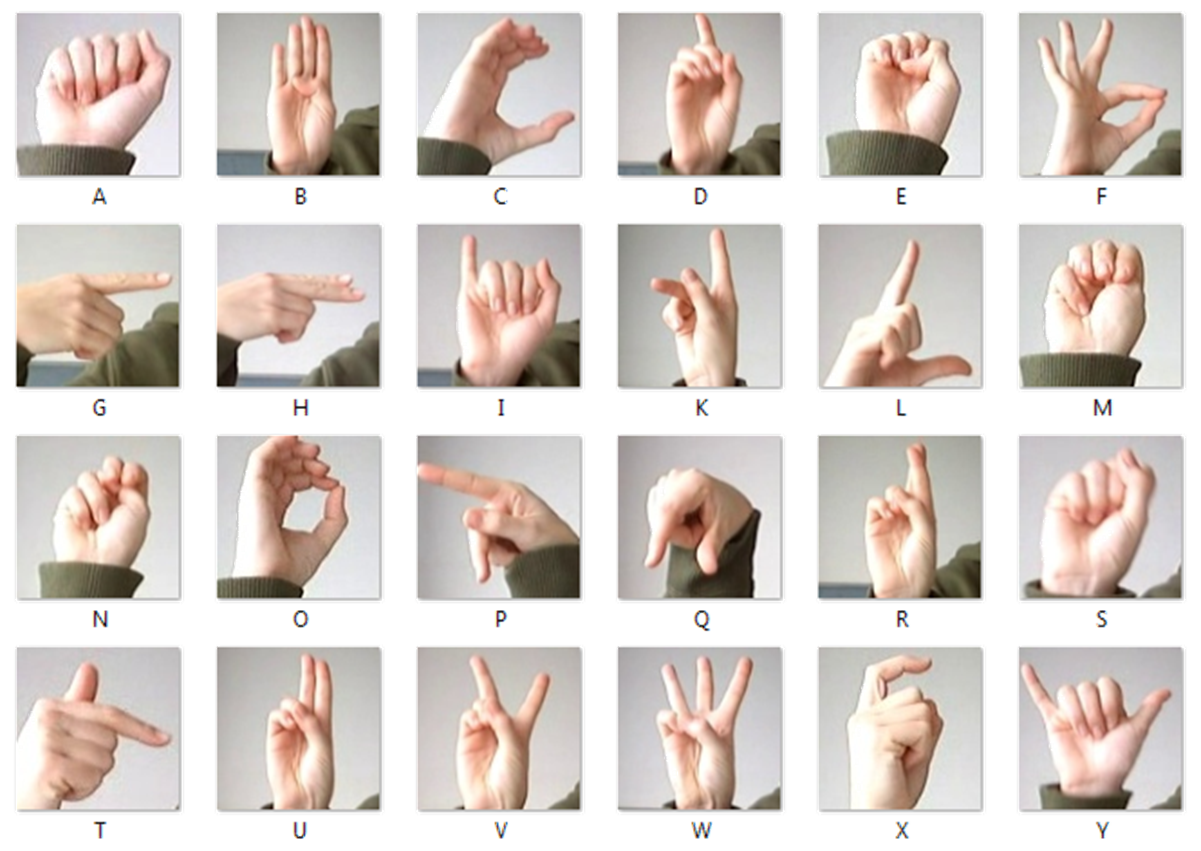

#### 1) 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 2) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [ ]:
path = '/content/drive/MyDrive/KT_AIVLE_SCHOOL/1118_7차프로젝트_수어번역/교육생용/data/sign_language.csv'

data = pd.read_csv(path)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
data.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [ ]:
data.shape

(27455, 785)

#### 3) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [ ]:
import string
class_names = list(string.ascii_lowercase)
len(class_names), class_names

(26,
 ['a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z'])

## 2 데이터 살펴보기

* 데이터 한 건을 2차원으로 변환하고 그림 그리기

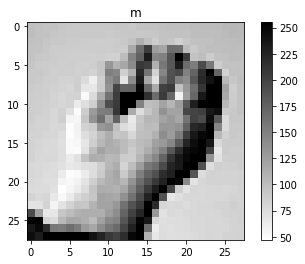

In [ ]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

In [ ]:
# 1. 데이터 분할1
target = 'label'
x = data.drop(target, axis=1)
y = data[target]
print(x.shape, y.shape)

(27455, 784) (27455,)


In [ ]:
# 2. 데이터 분할2
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# 3. 스케일링
x_train = (x_train-x_train.min())/(x_train.max()-x_train.min())
x_val = (x_val-x_val.min())/(x_val.max()-x_val.min())

In [ ]:
x_train = x_train.values
x_val =  x_val.values

In [ ]:
# 4. shape 맞추기
x_train_cnn = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val_cnn = x_val.reshape(x_val.shape[0], 28, 28, 1)

In [ ]:
x_train_cnn.shape

(21964, 28, 28, 1)

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 25)
y_val = to_categorical(y_val, 25)

## 4.모델링
* 딥러닝을 이용하여 모델링 합시다.

#### 1) CNN 사용하기

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# 1. 세션 클리어
keras.backend.clear_session()

# 2. 함수 선언
model = keras.Sequential()

# 3. 레이어 추가
model.add(keras.layers.Input(shape=(28,28,1)))

model.add(keras.layers.Conv2D(filters=32,
                              kernel_size=(3,3),
                              padding='same',
                              activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(filters=32,
                              kernel_size=(3,3),
                              padding='same',
                              activation='relu'))
model.add(BatchNormalization())

model.add(keras.layers.MaxPool2D(pool_size=(2,2),
                                 strides=(2,2)))
model.add(Dropout(0.25))

model.add(keras.layers.Conv2D(filters=64,
                              kernel_size=(3,3),
                              padding='same',
                              activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(filters=64,
                              kernel_size=(3,3),
                              padding='same',
                              activation='relu'))
model.add(BatchNormalization())

model.add(keras.layers.MaxPool2D(pool_size=(2,2),
                                 strides=(2,2)))
model.add(Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(BatchNormalization())

model.add(keras.layers.Dense(25, activation='softmax'))

# 4. 모델 컴파일
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# 5. 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

history = model.fit(x_train_cnn, y_train, validation_split=0.2, epochs=128, verbose=1, callbacks=[es])

Epoch 1/128
550/550 [==============================] - 4s 7ms/step - loss: 0.0146 - accuracy: 0.9963 - val_loss: 2.1387 - val_accuracy: 0.6720
Epoch 2/128
550/550 [==============================] - 4s 7ms/step - loss: 0.0272 - accuracy: 0.9918 - val_loss: 4.5197e-04 - val_accuracy: 1.0000
Epoch 3/128
550/550 [==============================] - 4s 7ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 5.9311e-06 - val_accuracy: 1.0000
Epoch 4/128
550/550 [==============================] - 4s 7ms/step - loss: 8.6081e-04 - accuracy: 0.9996 - val_loss: 5.7551e-05 - val_accuracy: 1.0000
Epoch 5/128
550/550 [==============================] - 4s 7ms/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 4.4113e-04 - val_accuracy: 1.0000
Epoch 6/128
550/550 [==============================] - 4s 7ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 8.8609e-07 - val_accuracy: 1.0000
Epoch 7/128
550/550 [==============================] - 4s 7ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 2.081

#### 2) RandomForest 사용하기

In [ ]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(verbose=3)
rf.fit(x_train,y_train)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
predicted_rf = rf.predict(x_val)
print(accuracy_score(y_val.argmax(axis=1), predicted_rf.argmax(axis=1)))
print(confusion_matrix(y_val.argmax(axis=1), predicted_rf.argmax(axis=1)))
print(classification_report(y_val.argmax(axis=1), predicted_rf.argmax(axis=1)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


0.9306137315607358
[[221   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 12 176   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  5   0 215   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 27   0   0 229   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 10   0   0   0 192   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 16   0   0   0   0 226   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 16   0   0   0   0   0 205   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 10   0   0   0   0   0   0 195   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 23   0   0   0   0   0   0   0 196   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [ 23   0   0   0   0   0   0   0   0 196   0   0   0   0   0   0   0   

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished


## 5.모델 저장하기

### (1) 모델 저장하기

In [ ]:
model.save('/content/drive/MyDrive/KT_AIVLE_SCHOOL/1118_7차프로젝트_수어번역/교육생용/model/best_model.h5')

### (2) 모델 로딩하기

In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/KT_AIVLE_SCHOOL/1118_7차프로젝트_수어번역/교육생용/model/best_model.h5')

* 불러온 모델 사용하기

In [ ]:
predicted = loaded_model.predict(x_val_cnn)

172/172 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score

single_predicted = predicted.argmax(axis=1).reshape(-1)
print(accuracy_score(y_val.argmax(axis=1), single_predicted))

1.0


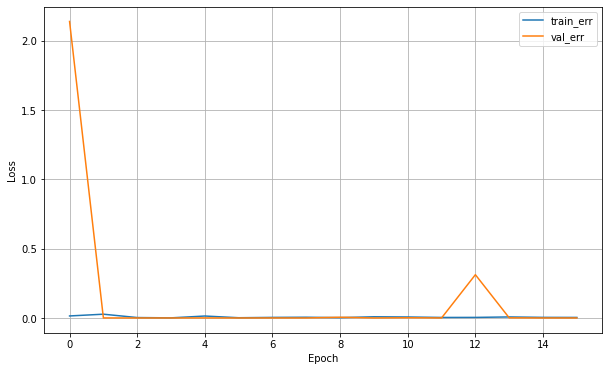

In [ ]:
dl_history_plot(history.history)

## 6.Data Pipeline 구성

### (1) 라이브러리 로딩

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

### (2) 테스트 데이터 로딩
* 제공받은 이미지로 테스트 해보기
* 직접 찍은 사진으로 테스트 해보기

In [ ]:
test_path = '/content/drive/MyDrive/KT_AIVLE_SCHOOL/1118_7차프로젝트_수어번역/교육생용/data/test image'

In [ ]:
test = []
label = []

In [ ]:
file_list = os.listdir(test_path)
for file in file_list:
  img = cv2.imread(test_path + '/' + file, cv2.IMREAD_GRAYSCALE)
  print(img.shape)
  img2 = cv2.resize(img, (28,28))
  cv2_imshow(img2)
  print(img2.shape)
  test.append(img2)
  label.append(file.split('.')[0])

(263, 263)


(28, 28)
(270, 264)


(28, 28)
(263, 255)


(28, 28)
(260, 228)


(28, 28)
(242, 230)


(28, 28)


### (3) Data Pipeline에 포함되어야 할 절차
* 이미지 크기 맞추기
* 흑백이미지
* 스케일링

In [ ]:
for i in range(len(test)):
  test_reshape = test[i].reshape(1, 28, 28, 1)
  img2_temp = test_reshape/255.
  predict = loaded_model.predict(img2_temp).argmax(axis=1)
  print('예측 :', class_names[predict[0]])
  print('정답 :', label[i])

1/1 [==============================] - 0s 46ms/step
예측 : a
정답: a
1/1 [==============================] - 0s 69ms/step
예측 : l
정답: l
1/1 [==============================] - 0s 50ms/step
예측 : o
정답: o
1/1 [==============================] - 0s 75ms/step
예측 : v
정답: v
1/1 [==============================] - 0s 26ms/step
예측 : e
정답: e


### (4) 하나의 셀로 합치기

* 폴더 구조를 만들어 놓고 개발하기 필요한 코드를 하나로 모으기

In [ ]:
def pipeline(filepath, modelpath):
  import pandas as pd
  import numpy as np
  import cv2
  from keras.models import load_model
  import string

  # class names 준비 -> 함수 밖 추천
  class_names = list(string.ascii_lowercase)
  len(class_names), class_names

  # 파일 로딩
  img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

  # 크기 조정
  img = cv2.resize(img, (28,28))

  # input scale 맞추기
  img = img.reshape(1, 28, 28, 1)

  # 스케일링
  img = img/255.

  # 모델 로딩 -> 함수 밖 추천
  model = load_model(modelpath)

  # 예측
  predicted = model.predict(img)

  return predicted.argmax(axis=1)

In [ ]:
test_path = '/content/drive/MyDrive/KT_AIVLE_SCHOOL/1118_7차프로젝트_수어번역/교육생용/data/test image'

file_list = os.listdir(test_path)
for file in file_list:
  test_single_path = test_path + '/' + file
  print(pipeline(test_single_path, '/content/drive/MyDrive/KT_AIVLE_SCHOOL/1118_7차프로젝트_수어번역/교육생용/model/best_model.h5'))

1/1 [==============================] - 0s 178ms/step
[0]
1/1 [==============================] - 0s 214ms/step
[11]
1/1 [==============================] - 0s 106ms/step
[14]
1/1 [==============================] - 0s 106ms/step
[21]
1/1 [==============================] - 0s 116ms/step
[4]
